# 2.4 Compare group model and individual models in tensorflow

In [14]:
import numpy as np
import pandas as pd
import torch
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from dataset import create_train_test_file_list, Person_MealsDataset, balance_data_indices


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [15]:
import sys
import numpy as np
from numpy.random import seed
### imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Turn off TensorFlow logging
import tensorflow as tf
random_seed  = 1000
seed(random_seed)
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

import numpy as np
import pandas as pd
import random
#from sklearn.metrics import classification_report, confusion_matrix
from datetime import datetime
import loadfile
import addons

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Input, add
# from tensorflow.keras.utils import np_utils
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import load_model, save_model, Model


from dataset import create_train_test_file_list, Person_MealsDataset, balance_data_indices
from utils import *
from model import *


tf.__version__

'2.3.0'

## General Settings

In [16]:

shimmer_global_mean = [-0.012359981,-0.0051663737,0.011612018,
                        0.05796114,0.1477952,-0.034395125 ]

shimmer_global_stddev = [0.05756385,0.040893298,0.043825723,
                        17.199743,15.311142,21.229317 ]

shimmer_trended_mean = [-0.000002,-0.000002,-0.000000,
                0.058144,0.147621,-0.033260 ]

shimmer_trended_stddev = [0.037592,0.034135,0.032263,
                17.209038,15.321441,21.242532 ]

all_zero_means = [0,0,0,0,0,0]

meanvals = all_zero_means
stdvals = shimmer_trended_stddev




In [61]:
def test_model(model, winmin=3, stridesec = 15,names= ["wenkanw"],random_seed=1000, split_day=False):
    perf = {"name":[],"model":[],"win(sec)":[], "acc":[],"recall":[], "auc":[]}
    for name in names:
        person = name
        if split_day:
            meal_data_test = Person_MealsDataset(person_name= person, file_name = "test_files", winmin = winmin,stridesec = stridesec)

            # balance test set
            testset_labels = meal_data_test.labels
            test_indices = balance_data_indices(testset_labels,data_indices=[i for i in range(len(meal_data_test))] ,mode="under", shuffle=True,random_state = random_seed,replace= False)
            # get numpy dataset
            test_Data, test_Labels = meal_data_test.get_subset(test_indices)
        else:            
            meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = winmin,stridesec = stridesec)
            samples,labels =  meal_data.data_indices, meal_data.labels
            # split train set and test set
            train_indices, test_indices = split_train_test_indices(X= [i for i in range(len(labels))],
                                                                            y = labels, test_size = 0.2,
                                                                           random_seed = random_seed)
            testset_labels = labels[test_indices]
            test_indices = balance_data_indices(testset_labels,data_indices= test_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)
            test_Data, test_Labels = meal_data.get_subset(test_indices)
            
        from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
        predictions = model.predict(x=test_Data)
        threshold = 0.5
        acc =  accuracy_score(predictions>=threshold,test_Labels)
        recall = recall_score(predictions>=threshold,test_Labels)
        auc = roc_auc_score(predictions>=threshold,test_Labels)
        print("Test Accuracy:", acc)
        print("Recall Accuracy:", recall)
        print("AUC Score:", auc)
        perf["name"].append(name)
        perf["model"].append("ActiModel")
        perf["win(sec)"].append(winmin*60)
        perf["acc"].append(acc)
        perf["recall"].append(recall)
        perf["auc"].append(auc)

    perf_df = pd.DataFrame(perf)
    return perf_df

In [5]:
perf = {"model":[],"win(sec)":[], "acc":[],"recall":[], "auc":[]}

In [6]:

def test_windowsize_v1(win_ls = [],EPOCHS = 10,stridesec = 1,name = "wenkanw", random_seed= 1000):
    from numpy.random import seed
    
    from datetime  import datetime
    batch_size = 128
    outfile = sys.stdout
    perf = {"model":[],"win(sec)":[], "acc":[],"recall":[], "auc":[]}
    model_ls = []
    hist_ls = []
    seed(random_seed)
    tf.random.set_seed(random_seed)
#     tf.set_random_seed(random_seed)
    
    for winsize in win_ls:
        
        winmin = winsize
        winlength = int(winmin * 60 * 15)
        step = int(stridesec * 15)
        start_time = datetime.now()
        arr = ["echo -n 'PBS: node is '; cat $PBS_NODEFILE",\
              "echo PBS: job identifier is $PBS_JOBID",\
              "echo PBS: job name is $PBS_JOBNAME"]
        [os.system(cmd) for cmd in arr]
        print("*****************************************************************\n", file=outfile, flush=True)
        print("Execution Started at " + start_time.strftime("%m/%d/%Y, %H:%M:%S"), file=outfile, flush=True)
        print("WindowLength: {:.2f} min ({:d} datum)\tSlide: {:d} ({:d} datum)\tEpochs:{:d}\n".format(winmin, winlength, stridesec, step, EPOCHS), file=outfile, flush=True)


        pathtemp = "../models/ActiModels/"+name+"_"+"M_F_"
        modelpath = pathtemp + "{:f}Min.h5".format(winmin)
        jsonpath = pathtemp + "{:f}Min.json".format(winmin)
        # Load the dataset
        
        person = name
        meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = winmin,stridesec = stridesec)
        samples,labels =  meal_data.data_indices, meal_data.labels
        # split train set and test set
        train_indices, test_indices = split_train_test_indices(X= [i for i in range(len(labels))],
                                                                y = labels, test_size = 0.2,
                                                               random_seed = random_seed)
        # balance train set
        trainset_labels = labels[train_indices]
        train_indices_balanced = balance_data_indices(trainset_labels,data_indices= train_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)
        
        testset_labels = labels[test_indices]
        test_indices = balance_data_indices(testset_labels,data_indices= test_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)
        
        
        train_set_balanced = torch.utils.data.Subset(meal_data, train_indices_balanced)
        test_set = torch.utils.data.Subset(meal_data, test_indices)
        
        
        # data loadeer used for pytorch neural network model
        train_loader = torch.utils.data.DataLoader(train_set_balanced,batch_size=batch_size, shuffle=True,num_workers=2)
        test_loader = torch.utils.data.DataLoader(test_set ,batch_size=batch_size, shuffle=True,num_workers=2)

        print("Data Loader Created")
        
        # Split validation set
        # split validation set
        balanced_trainset_labels = labels[train_indices_balanced]
        train_indices, valid_indices = split_train_test_indices(X= train_indices_balanced,
                                                                y = balanced_trainset_labels, test_size = 0.2,
                                                               random_seed = random_seed)

        valid_set_balanced = torch.utils.data.Subset(meal_data, valid_indices)
        valid_loader = torch.utils.data.DataLoader(valid_set_balanced,batch_size=batch_size, shuffle=True,num_workers=2)
        
        # Convert pytorch dataset to numpy array to train tensorflow model
        balancedData, balancedLabels = meal_data.get_subset(train_indices)
        valid_balancedData, valid_balancedLabels = meal_data.get_subset(valid_indices)
        test_Data, test_Labels = meal_data.get_subset(test_indices)
        
#         return train_indices, valid_indices
        
        # Create models
#         K.get_session().close()
#         K.set_session(tf.Session())
#         K.get_session().run(tf.global_variables_initializer())

        mcp_save = tf.keras.callbacks.ModelCheckpoint(modelpath, save_best_only=True, monitor='accuracy')
        model = Sequential()
        model.add(Conv1D(10, 44, strides=2,activation='relu', input_shape=(winlength, 6)))
        model.add(Conv1D(10, 20, strides=2, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
        model.add(Conv1D(10, 4, strides=2, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01)))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])

        H = model.fit(x=balancedData, y = balancedLabels,
                       validation_data=(valid_balancedData, valid_balancedLabels),
                    epochs = EPOCHS, batch_size=batch_size, verbose=1,
                    callbacks=[mcp_save])

        print("Max value: ", max(H.history['accuracy']), " at epoch", np.argmax(H.history['accuracy']) + 1)

        from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
        predictions = model.predict(x=test_Data)
        threshold = 0.5
        acc =  accuracy_score(predictions>=threshold,test_Labels)
        recall = recall_score(predictions>=threshold,test_Labels)
        auc = roc_auc_score(predictions>=threshold,test_Labels)
        print("Test Accuracy:", acc)
        print("Recall Accuracy:", recall)
        print("AUC Score:", auc)

        perf["model"].append("ActiModel")
        perf["win(sec)"].append(winmin*60)
        perf["acc"].append(acc)
        perf["recall"].append(recall)
        perf["auc"].append(auc)
        model_ls.append(model)
        hist_ls.append(H)
    perf_df = pd.DataFrame(perf)
    print(perf_df)
    return perf_df, model_ls, hist_ls
    

In [21]:
acti_perf_df_1, acti_model_ls_1, acti_hist_ls_1 = test_windowsize_v1(win_ls = [1],EPOCHS = 30,stridesec = 5,name = "wenkanw")

*****************************************************************

Execution Started at 12/21/2020, 13:01:59
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/10-10-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-3-20/10-3-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Lo

In [22]:
acti_perf_df_2, acti_model_ls_2, acti_hist_ls_2 = test_windowsize_v1(win_ls = [1],EPOCHS = 30,stridesec = 5,name = "adam")

*****************************************************************

Execution Started at 12/21/2020, 13:03:07
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Loading Dataset ...
Loading File:  ../data/IndividualData/adam-data/09-22-2020/09-22-2020.shm
Loading File:  ../data/IndividualData/adam-data/10-28-2020/10-28-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-09-2020/11-09-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-11-2020/11-11-2020-1.shm
Loading File:  ../data/IndividualData/adam-data/11-12-2020/11-12-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-16-2020/11-16-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-17-2020/11-17-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-24-2020/11-24-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-25-2020/11-25-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-26-2020/11-26-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-30-2020/11-3

In [23]:
acti_perf_df_3, acti_model_ls_3, acti_hist_ls_3 = test_windowsize_v1(win_ls = [1],EPOCHS = 30,stridesec = 5,name = "lawler")

*****************************************************************

Execution Started at 12/21/2020, 13:03:51
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Loading Dataset ...
Loading File:  ../data/IndividualData/lawler-data/10.10/10.10.shm
Loading File:  ../data/IndividualData/lawler-data/10.12/10.12.shm
Loading File:  ../data/IndividualData/lawler-data/10.14/10.14.shm
Loading File:  ../data/IndividualData/lawler-data/10.16/10.16.shm
Loading File:  ../data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../data/IndividualData/lawler-data/10.20/afternoon_2hr33min/10.20.shm
Loading File:  ../data/IndividualData/lawler-data/10.20/evening_2hr_20min/10.20.shm
Loading File:  ../data/IndividualData/lawler-data/10.21/10.21.shm
Loading File:  ../data/IndividualData/lawler-data/10.26/10.26.shm
Loading File:  ../data/IndividualData/lawler-data/10.28/10.28.shm
Loading File:  ../data/IndividualData/lawler-data/10.31/10.31.shm
Loading File:  ../data/IndividualData/lawl

In [24]:
acti_perf_df_4, acti_model_ls_4, acti_hist_ls_4 = test_windowsize_v1(win_ls = [1],EPOCHS = 30,stridesec = 5,name = "shaurya")

*****************************************************************

Execution Started at 12/21/2020, 13:04:58
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Loading Dataset ...
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.25.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.1.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.15.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.17.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.18.2020/Data.shm
Train set size: 37752, with 2265 positive samples and 35487 negative samples
Test set size: 9438, with 566 positive samples and 8872 negative samples
Data Loader Created
Train set size: 3624, with 1812 positive samples and 1812 negative samples
Test set size: 906, with 453 positive samples and 453 negative samples
Epoch 1/30
29/29 [==============================] - 1s 35ms/step

In [25]:
acti_perf_df_group, acti_model_ls_group, acti_hist_ls_group = test_windowsize_v1(win_ls = [1],EPOCHS = 30,stridesec = 5,name = "CAD")

*****************************************************************

Execution Started at 12/21/2020, 13:05:34
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Loading Dataset ...
Loading File:  ../data/ShimmerData/P2001/P2001.shm
Loading File:  ../data/ShimmerData/P2011/P2011.shm
Loading File:  ../data/ShimmerData/P2012/P2012.shm
Loading File:  ../data/ShimmerData/P2013/P2013.shm
Loading File:  ../data/ShimmerData/P2014/P2014.shm
Loading File:  ../data/ShimmerData/P2015/P2015.shm
Loading File:  ../data/ShimmerData/P2016/P2016.shm
Loading File:  ../data/ShimmerData/P2017/P2017.shm
Loading File:  ../data/ShimmerData/P2018/P2018.shm
Loading File:  ../data/ShimmerData/P2020/P2020.shm
Loading File:  ../data/ShimmerData/P2030/P2030.shm
Loading File:  ../data/ShimmerData/P2031/P2031.shm
Loading File:  ../data/ShimmerData/P2033/P2033.shm
Loading File:  ../data/ShimmerData/P2035/P2035.shm
Loading File:  ../data/ShimmerData/P2036/P2036.shm
Loading File:  ../data/ShimmerData/P2037

Loading File:  ../data/ShimmerData/P2246/P2246.shm
Loading File:  ../data/ShimmerData/P2247/P2247.shm
Loading File:  ../data/ShimmerData/P2248/P2248.shm
Loading File:  ../data/ShimmerData/P2249/P2249.shm
Loading File:  ../data/ShimmerData/P2250/P2250.shm
Loading File:  ../data/ShimmerData/P2251/P2251.shm
Loading File:  ../data/ShimmerData/P2253/P2253.shm
Loading File:  ../data/ShimmerData/P2254/P2254.shm
Loading File:  ../data/ShimmerData/P2255/P2255.shm
Loading File:  ../data/ShimmerData/P2256/P2256.shm
Loading File:  ../data/ShimmerData/P2257/P2257.shm
Loading File:  ../data/ShimmerData/P2258/P2258.shm
Loading File:  ../data/ShimmerData/P2259/P2259.shm
Loading File:  ../data/ShimmerData/P2262/P2262.shm
Loading File:  ../data/ShimmerData/P2263/P2263.shm
Loading File:  ../data/ShimmerData/P2264/P2264.shm
Loading File:  ../data/ShimmerData/P2265/P2265.shm
Loading File:  ../data/ShimmerData/P2267/P2267.shm
Loading File:  ../data/ShimmerData/P2268/P2268.shm
Loading File:  ../data/ShimmerD

Loading File:  ../data/ShimmerData/P2443/P2443.shm
Loading File:  ../data/ShimmerData/P2444/P2444.shm
Loading File:  ../data/ShimmerData/P2446/P2446.shm
Loading File:  ../data/ShimmerData/P2447/P2447.shm
Loading File:  ../data/ShimmerData/P2449/P2449.shm
Loading File:  ../data/ShimmerData/P2451/P2451.shm
Loading File:  ../data/ShimmerData/P2452/P2452.shm
Loading File:  ../data/ShimmerData/P2453/P2453.shm
Loading File:  ../data/ShimmerData/P2454/P2454.shm
Loading File:  ../data/ShimmerData/P2455/P2455.shm
Loading File:  ../data/ShimmerData/P2456/P2456.shm
Loading File:  ../data/ShimmerData/P2457/P2457.shm
Loading File:  ../data/ShimmerData/P2458/P2458.shm
Loading File:  ../data/ShimmerData/P2459/P2459.shm
Loading File:  ../data/ShimmerData/P2460/P2460.shm
Loading File:  ../data/ShimmerData/P2461/P2461.shm
Loading File:  ../data/ShimmerData/P2462/P2462.shm
Loading File:  ../data/ShimmerData/P2463/P2463.shm
Loading File:  ../data/ShimmerData/P2464/P2464.shm
Loading File:  ../data/ShimmerD

In [26]:
group_model = tf.keras.models.load_model('../models/ActiModels/CAD_M_F_1.000000Min.h5')
acti_perf_df_group = test_model(group_model, winmin=1,stridesec = 5,names= ["wenkanw","adam","lawler","shaurya"],random_seed=1000)


Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/10-10-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-3-20/10-3-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Dinner/Dinner.shm
Loading File:  ../data/

In [28]:
individual_model_1 = tf.keras.models.load_model('../models/ActiModels/wenkanw_M_F_1.000000Min.h5')
acti_perf_df_individual_1 = test_model(individual_model_1, winmin=1,stridesec = 5,names= ["wenkanw"],random_seed=1000)
acti_individual_model_2 = tf.keras.models.load_model('../models/ActiModels/adam_M_F_1.000000Min.h5')
acti_perf_df_individual_2 = test_model(individual_model_2, winmin=1,stridesec = 5,names= ["adam"],random_seed=1000)
individual_model_3 = tf.keras.models.load_model('../models/ActiModels/lawler_M_F_1.000000Min.h5')
acti_perf_df_individual_3 = test_model(individual_model_3, winmin=1,stridesec = 5,names= ["lawler"],random_seed=1000)
individual_model_4 = tf.keras.models.load_model('../models/ActiModels/shaurya_M_F_1.000000Min.h5')
acti_perf_df_individual_4 = test_model(individual_model_4, winmin=1,stridesec = 5,names= ["shaurya"],random_seed=1000)


Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/10-10-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-3-20/10-3-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-9-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/lunch/lunch.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Dinner/Dinner.shm
Loading File:  ../data/

In [36]:
acti_perf_df_group["name"] = "Group"
acti_perf_df_individual_1["name"]="wenkanw"
acti_perf_df_individual_2["name"]="adam"
acti_perf_df_individual_3["name"]="lawler"
acti_perf_df_individual_4["name"]="shaurya"
for i in range(len(perf_df_group)):
    acti_perf_df_group['model'].iloc[i]="group_model"
acti_perf_df_group['name'].at[0]="wenkanw"
acti_perf_df_group['name'].at[1]="adam"
acti_perf_df_group['name'].at[2]="lawler"
acti_perf_df_group['name'].at[3]="shaurya"

acti_perf_df_individual_1["model"]="individual_model"
acti_perf_df_individual_2["model"]="individual_model"
acti_perf_df_individual_3["model"]="individual_model"
acti_perf_df_individual_4["model"]="individual_model"
acti_performance = pd.concat([acti_perf_df_group,acti_perf_df_individual_1,acti_perf_df_individual_2,acti_perf_df_individual_3,acti_perf_df_individual_4],ignore_index=True)
acti_performance


/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,name,model,win(sec),acc,recall,auc
0,wenkanw,group_model,60,0.729693,0.849108,0.760129
1,adam,group_model,60,0.803892,0.902778,0.823384
2,lawler,group_model,60,0.661940,0.691974,0.666003
3,shaurya,group_model,60,0.702297,0.880399,0.759092
4,wenkanw,individual_model,60,0.856047,0.891758,0.859030
5,adam,individual_model,60,0.906437,0.905830,0.906438
6,lawler,individual_model,60,0.765782,0.813376,0.772058
7,shaurya,individual_model,60,0.805654,0.827652,0.807038


# My Tensorflow models

# My Model 2: ResNet

In [18]:
def residual_module(layer_in, n_filters):
            merge_input = layer_in
            # check if the number of filters needs to be increase, assumes channels last format
            if layer_in.shape[-1] != n_filters:
                merge_input = Conv1D(n_filters, (1,), padding='same', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l1(0.01))(layer_in)
            # conv1
            # L2 for avoiding overfitting
            conv1 = Conv1D(n_filters, (5,), padding='same', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(layer_in)
            # Batch normal for re-scaling data and better fit data
            conv1 = tf.keras.layers.BatchNormalization(1)(conv1)
            conv1 = tf.keras.layers.ReLU()(conv1)
            # conv2
            conv2 = Conv1D(n_filters, (5,), padding='same', kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01))(conv1)
            conv2 = tf.keras.layers.BatchNormalization(1)(conv2)
            
            # add filters, assumes filters/channels last
            #out = conv2
            out = add([conv2, merge_input])
            # activation function
            layer_out = Activation('relu')(out)
            return layer_out
        

def my_model(input_shape):
            in_layer = Input(shape = input_shape)
            out = Conv1D(10, 40, strides=2)(in_layer)
            out = residual_module(layer_in= out,  n_filters=10)
            out = residual_module(layer_in= out,  n_filters=10)
            out = GlobalAveragePooling1D()(out)
            # L1 for feature selection
            out = Dense(200, activation='relu',kernel_regularizer=tf.keras.regularizers.l1(0.01))(out)
            out = Dense(1, activation='sigmoid')(out)
            model = Model(inputs=in_layer, outputs=out)
            return model
        
# newmodel = my_model(input_shape =(900,6) )

# newmodel.compile(loss='binary_crossentropy',
#                 optimizer='adam', metrics=['accuracy'])


In [19]:

from dataset import create_train_test_file_list, Person_MealsDataset, balance_data_indices
from utils import *
from model import *
def train_models_v2(model, win_ls = [],EPOCHS = 10,stridesec = 1,name = "wenkanw",model_name="v2" ,random_seed= 1000, split_day=False):
    from numpy.random import seed
    seed(random_seed)
    random.seed(random_seed)
#     tf.set_random_seed(random_seed)
    from datetime  import datetime
    batch_size = 128
    outfile = sys.stdout
    perf = {"model":[],"win(sec)":[], "acc":[],"recall":[], "auc":[]}
    model_ls = []
    hist_ls = []
    for winsize in win_ls:
        tf.random.set_seed(random_seed)
        seed(random_seed)
        
        winmin = winsize
        winlength = int(winmin * 60 * 15)
        step = int(stridesec * 15)
        start_time = datetime.now()
        arr = ["echo -n 'PBS: node is '; cat $PBS_NODEFILE",\
              "echo PBS: job identifier is $PBS_JOBID",\
              "echo PBS: job name is $PBS_JOBNAME"]
        [os.system(cmd) for cmd in arr]
        print("*****************************************************************\n", file=outfile, flush=True)
        print("Execution Started at " + start_time.strftime("%m/%d/%Y, %H:%M:%S"), file=outfile, flush=True)
        print("WindowLength: {:.2f} min ({:d} datum)\tSlide: {:d} ({:d} datum)\tEpochs:{:d}\n".format(winmin, winlength, stridesec, step, EPOCHS), file=outfile, flush=True)


        pathtemp = "../models/" + name+"_models" +"/"+model_name+"_M_F_"
        modelpath = pathtemp + "{:f}Min.h5".format(winmin)
        jsonpath = pathtemp + "{:f}Min.json".format(winmin)
        print("Model to Save: ",modelpath)
        print()
        # Load the dataset
        
        person = name
        if split_day:
            create_train_test_file_list(file_name= "all_files_list.txt",person_name =name,
                         out_path = "../data-file-indices/",root_path= "../",
                         test_ratio = 0.2, print_flag = True, shuffle=True, random_state=random_seed)

            meal_data_train = Person_MealsDataset(person_name= person, file_name = "train_files", winmin = winmin,stridesec = stridesec)
            meal_data_test = Person_MealsDataset(person_name= person, file_name = "test_files", winmin = winmin,stridesec = stridesec)

            train_indices, valid_indices = split_train_test_indices(X= [i for i in range(len(meal_data_train.labels))],
                                                                    y = meal_data_train.labels, test_size = 0.2,
                                                                   random_seed = random_seed)
            #balanced train set
            trainset_labels = meal_data_train.labels[train_indices]
            train_indices = balance_data_indices(trainset_labels,data_indices= train_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)

            # balance test set
            testset_labels = meal_data_test.labels
            test_indices = balance_data_indices(testset_labels,data_indices=[i for i in range(len(meal_data_test))] ,mode="under", shuffle=True,random_state = random_seed,replace= False)
            # get numpy dataset
            balancedData, balancedLabels = meal_data_train.get_subset(train_indices)
            valid_balancedData, valid_balancedLabels = meal_data_train.get_subset(valid_indices)
            test_Data, test_Labels = meal_data_test.get_subset(test_indices)

        else:
        
            meal_data = Person_MealsDataset(person_name= person, file_name = "all_files_list", winmin = winmin,stridesec = stridesec)
            samples,labels =  meal_data.data_indices, meal_data.labels
            # split train set and test set
            train_indices, test_indices = split_train_test_indices(X= [i for i in range(len(labels))],
                                                                    y = labels, test_size = 0.2,
                                                                   random_seed = random_seed)
            # balance train set
            trainset_labels = labels[train_indices]
            train_indices_balanced = balance_data_indices(trainset_labels,data_indices= train_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)
            #balance test set
            testset_labels = labels[test_indices]
            test_indices = balance_data_indices(testset_labels,data_indices= test_indices,mode="under", shuffle=True,random_state = random_seed,replace= False)

            train_set_balanced = torch.utils.data.Subset(meal_data, train_indices_balanced)
            test_set = torch.utils.data.Subset(meal_data, test_indices)

            train_loader = torch.utils.data.DataLoader(train_set_balanced,batch_size=batch_size, shuffle=True,num_workers=2)
            test_loader = torch.utils.data.DataLoader(test_set ,batch_size=batch_size, shuffle=True,num_workers=2)

            print("Data Loader Created")            
            
            # split validation set
            balanced_trainset_labels = labels[train_indices_balanced]
            train_indices, valid_indices = split_train_test_indices(X= train_indices_balanced,
                                                                    y = balanced_trainset_labels, test_size = 0.2,
                                                                   random_seed = random_seed)
            valid_set_balanced = torch.utils.data.Subset(meal_data, valid_indices)
            valid_loader = torch.utils.data.DataLoader(valid_set_balanced,batch_size=batch_size, shuffle=True,num_workers=2)

            balancedData, balancedLabels = meal_data.get_subset(train_indices)
            valid_balancedData, valid_balancedLabels = meal_data.get_subset(valid_indices)
            test_Data, test_Labels = meal_data.get_subset(test_indices)
        

        #training settings
        mcp_save = tf.keras.callbacks.ModelCheckpoint(modelpath, save_best_only=True, monitor='accuracy')
        

        scheduler = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.1, patience=3, verbose=0,
                                             mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.)
        #train model
        H = model.fit(x=balancedData, y = balancedLabels,
                       validation_data=(valid_balancedData, valid_balancedLabels),
                    epochs = EPOCHS, batch_size=batch_size, verbose=1,
                    callbacks=[mcp_save,scheduler]) # removed addons.LossHistory(jsonpath) for compatibility with TensorFlow 2.2.0, needs to be re-added at some point

        print("Max value: ", max(H.history['accuracy']), " at epoch", np.argmax(H.history['accuracy']) + 1)

        from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
        predictions = model.predict(x=test_Data)
        threshold = 0.5
        acc =  accuracy_score(predictions>=threshold,test_Labels)
        recall = recall_score(predictions>=threshold,test_Labels)
        auc = roc_auc_score(predictions>=threshold,test_Labels)
        print("Test Accuracy:", acc)
        print("Recall Accuracy:", recall)
        print("AUC Score:", auc)

        perf["model"].append("ActiModel")
        perf["win(sec)"].append(winmin*60)
        perf["acc"].append(acc)
        perf["recall"].append(recall)
        perf["auc"].append(auc)
        model_ls.append(model)
        hist_ls.append(H)
    perf_df = pd.DataFrame(perf)
    print(perf_df)
    return perf_df, model_ls, hist_ls
    

In [9]:
winmin= 1
win_size = 15*winmin*60
model_1 = my_model(input_shape =(900,6) )
model_1.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_1, model_ls_1, hist_ls_1 = train_models_v2(model_1,win_ls = [1],EPOCHS = 30,stridesec = 5,model_name="resnet",name = "wenkanw")

*****************************************************************

Execution Started at 12/21/2020, 19:24:06
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Model to Save:  ../models/wenkanw_models/resnet_M_F_1.000000Min.h5

Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-27-20/9-27-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-10-20/10-10-20.shm
Loading

In [1]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
H = hist_ls_1[0].history
H_df = pd.DataFrame(H)
_ = sns.lineplot(data =H_df[["accuracy","val_accuracy"]],ax=ax[0])
_ = sns.lineplot(data =H_df[["loss"]],ax=ax[1])


NameError: name 'plt' is not defined

In [10]:
winmin= 1
win_size = 15*winmin*60
model_2 = my_model(input_shape =(900,6) )
model_2.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_2, model_ls_2, hist_ls_2 = train_models_v2(model_2,win_ls = [1],EPOCHS = 30,stridesec = 5,model_name="resnet",name = "adam")

*****************************************************************

Execution Started at 12/21/2020, 19:26:21
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Model to Save:  ../models/adam_models/resnet_M_F_1.000000Min.h5

Loading Dataset ...
Loading File:  ../data/IndividualData/adam-data/12-11-2020/12-11-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-24-2020/11-24-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-26-2020/11-26-2020.shm
Loading File:  ../data/IndividualData/adam-data/10-28-2020/10-28-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-03-2020/12-03-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-09-2020/12-09-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-11-2020/11-11-2020-1.shm
Loading File:  ../data/IndividualData/adam-data/12-10-2020/12-10-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-30-2020/11-30-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-01-2020/12-01-2020.sh

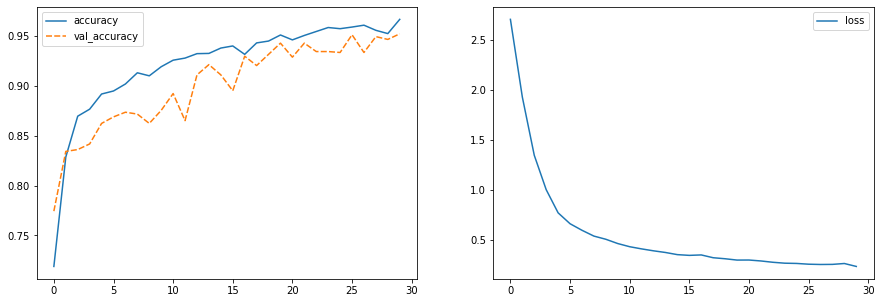

In [56]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
H = hist_ls_2[0].history
H_df = pd.DataFrame(H)
_ = sns.lineplot(data =H_df[["accuracy","val_accuracy"]],ax=ax[0])
_ = sns.lineplot(data =H_df[["loss"]],ax=ax[1])


In [11]:
winmin= 1
win_size = 15*winmin*60
model_3 = my_model(input_shape =(900,6) )
model_3.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_3, model_ls_3, hist_ls_3 = train_models_v2(model_3,win_ls = [1],EPOCHS = 30,stridesec = 5,model_name="resnet",name = "lawler")

*****************************************************************

Execution Started at 12/21/2020, 19:27:46
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Model to Save:  ../models/lawler_models/resnet_M_F_1.000000Min.h5

Loading Dataset ...
Loading File:  ../data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../data/IndividualData/lawler-data/10.16/10.16.shm
Loading File:  ../data/IndividualData/lawler-data/9.23/9.23_13hr.shm
Loading File:  ../data/IndividualData/lawler-data/10.20/afternoon_2hr33min/10.20.shm
Loading File:  ../data/IndividualData/lawler-data/10.26/10.26.shm
Loading File:  ../data/IndividualData/lawler-data/9.25/9.25_1-46.shm
Loading File:  ../data/IndividualData/lawler-data/11.4/11.4.shm
Loading File:  ../data/IndividualData/lawler-data/10.8/10.8.shm
Loading File:  ../data/IndividualData/lawler-data/10.12/10.12.shm
Loading File:  ../data/IndividualData/lawler-data/11.14/11.14.shm
Loading File:  ../data/IndividualData/lawler-data/10.14/1

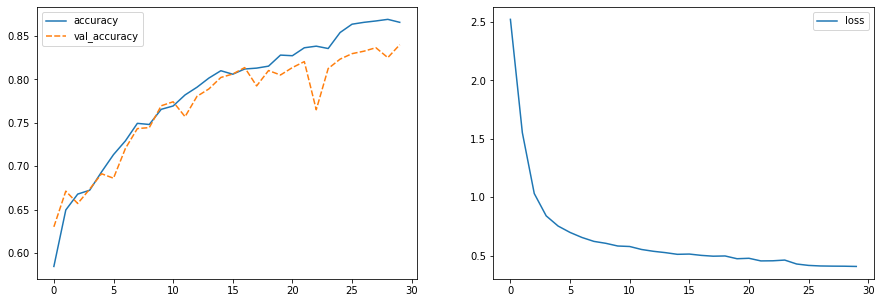

In [55]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
H = hist_ls_3[0].history
H_df = pd.DataFrame(H)
_ = sns.lineplot(data =H_df[["accuracy","val_accuracy"]],ax=ax[0])
_ = sns.lineplot(data =H_df[["loss"]],ax=ax[1])


In [12]:
winmin= 1
win_size = 15*winmin*60
model_4 = my_model(input_shape =(900,6) )
model_4.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_4, model_ls_4, hist_ls_4 = train_models_v2(model_4,win_ls = [1],EPOCHS = 30,stridesec = 5,model_name="resnet",name = "shaurya")

*****************************************************************

Execution Started at 12/21/2020, 19:29:59
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Model to Save:  ../models/shaurya_models/resnet_M_F_1.000000Min.h5

Loading Dataset ...
Loading File:  ../data/IndividualData/shaurya-data/11.1.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.25.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.15.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.17.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/10.22.2020/Data.shm
Loading File:  ../data/IndividualData/shaurya-data/11.18.2020/Data.shm
Train set size: 37752, with 2265 positive samples and 35487 negative samples
Test set size: 9438, with 566 positive samples and 8872 negative samples
Data Loader Created
Train set size: 3624, with 1812 positive samples and 1812 negative samples
Test set size: 906, with 453 positive samples and 453 negative samp

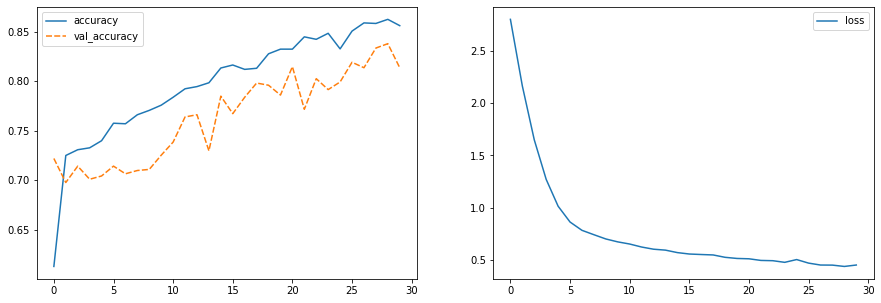

In [54]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
H = hist_ls_4[0].history
H_df = pd.DataFrame(H)
_ = sns.lineplot(data =H_df[["accuracy","val_accuracy"]],ax=ax[0])
_ = sns.lineplot(data =H_df[["loss"]],ax=ax[1])


In [20]:
winmin= 1
win_size = 15*winmin*60
model_5 = my_model(input_shape =(900,6) )
model_5.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_5, model_ls_5, hist_ls_5 = train_models_v2(model_5,win_ls = [1],EPOCHS = 30,stridesec = 5,model_name="resnet",name = "CAD")

*****************************************************************

Execution Started at 12/21/2020, 20:10:47
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Model to Save:  ../models/CAD_models/resnet_M_F_1.000000Min.h5

Loading Dataset ...
Loading File:  ../data/ShimmerData/P2001/P2001.shm
Loading File:  ../data/ShimmerData/P2011/P2011.shm
Loading File:  ../data/ShimmerData/P2012/P2012.shm
Loading File:  ../data/ShimmerData/P2013/P2013.shm
Loading File:  ../data/ShimmerData/P2014/P2014.shm
Loading File:  ../data/ShimmerData/P2015/P2015.shm
Loading File:  ../data/ShimmerData/P2016/P2016.shm
Loading File:  ../data/ShimmerData/P2017/P2017.shm
Loading File:  ../data/ShimmerData/P2018/P2018.shm
Loading File:  ../data/ShimmerData/P2020/P2020.shm
Loading File:  ../data/ShimmerData/P2030/P2030.shm
Loading File:  ../data/ShimmerData/P2031/P2031.shm
Loading File:  ../data/ShimmerData/P2033/P2033.shm
Loading File:  ../data/ShimmerData/P2035/P2035.shm
Loading File:  ../data/Shim

Loading File:  ../data/ShimmerData/P2245/P2245.shm
Loading File:  ../data/ShimmerData/P2246/P2246.shm
Loading File:  ../data/ShimmerData/P2247/P2247.shm
Loading File:  ../data/ShimmerData/P2248/P2248.shm
Loading File:  ../data/ShimmerData/P2249/P2249.shm
Loading File:  ../data/ShimmerData/P2250/P2250.shm
Loading File:  ../data/ShimmerData/P2251/P2251.shm
Loading File:  ../data/ShimmerData/P2253/P2253.shm
Loading File:  ../data/ShimmerData/P2254/P2254.shm
Loading File:  ../data/ShimmerData/P2255/P2255.shm
Loading File:  ../data/ShimmerData/P2256/P2256.shm
Loading File:  ../data/ShimmerData/P2257/P2257.shm
Loading File:  ../data/ShimmerData/P2258/P2258.shm
Loading File:  ../data/ShimmerData/P2259/P2259.shm
Loading File:  ../data/ShimmerData/P2262/P2262.shm
Loading File:  ../data/ShimmerData/P2263/P2263.shm
Loading File:  ../data/ShimmerData/P2264/P2264.shm
Loading File:  ../data/ShimmerData/P2265/P2265.shm
Loading File:  ../data/ShimmerData/P2267/P2267.shm
Loading File:  ../data/ShimmerD

Loading File:  ../data/ShimmerData/P2443/P2443.shm
Loading File:  ../data/ShimmerData/P2444/P2444.shm
Loading File:  ../data/ShimmerData/P2446/P2446.shm
Loading File:  ../data/ShimmerData/P2447/P2447.shm
Loading File:  ../data/ShimmerData/P2449/P2449.shm
Loading File:  ../data/ShimmerData/P2451/P2451.shm
Loading File:  ../data/ShimmerData/P2452/P2452.shm
Loading File:  ../data/ShimmerData/P2453/P2453.shm
Loading File:  ../data/ShimmerData/P2454/P2454.shm
Loading File:  ../data/ShimmerData/P2455/P2455.shm
Loading File:  ../data/ShimmerData/P2456/P2456.shm
Loading File:  ../data/ShimmerData/P2457/P2457.shm
Loading File:  ../data/ShimmerData/P2458/P2458.shm
Loading File:  ../data/ShimmerData/P2459/P2459.shm
Loading File:  ../data/ShimmerData/P2460/P2460.shm
Loading File:  ../data/ShimmerData/P2461/P2461.shm
Loading File:  ../data/ShimmerData/P2462/P2462.shm
Loading File:  ../data/ShimmerData/P2463/P2463.shm
Loading File:  ../data/ShimmerData/P2464/P2464.shm
Loading File:  ../data/ShimmerD

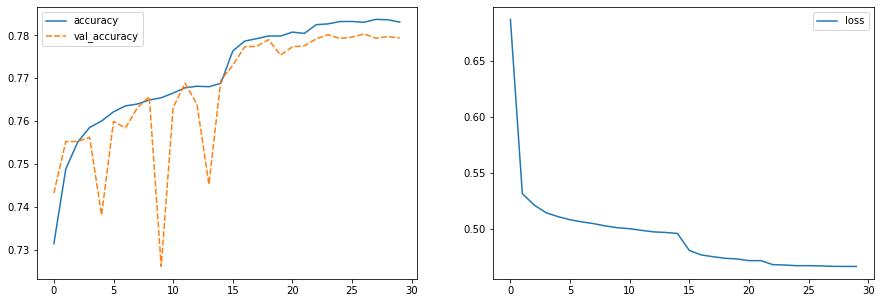

In [53]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
H = hist_ls_5[0].history
H_df = pd.DataFrame(H)
_ = sns.lineplot(data =H_df[["accuracy","val_accuracy"]],ax=ax[0])
_ = sns.lineplot(data =H_df[["loss"]],ax=ax[1])


In [21]:
group_model = tf.keras.models.load_model('../models/CAD_models/resnet_M_F_1.000000Min.h5')
perf_df_group = test_model(group_model, winmin=1,stridesec = 5,names= ["wenkanw","adam","lawler","shaurya"],random_seed=1000)

individual_model_1 = tf.keras.models.load_model('../models/wenkanw_models/resnet_M_F_1.000000Min.h5')
perf_df_individual_1 = test_model(individual_model_1, winmin=1,stridesec = 5,names= ["wenkanw"],random_seed=1000)

individual_model_2 = tf.keras.models.load_model('../models/adam_models/resnet_M_F_1.000000Min.h5')
perf_df_individual_2 = test_model(individual_model_2, winmin=1,stridesec = 5,names= ["adam"],random_seed=1000)

individual_model_3 = tf.keras.models.load_model('../models/lawler_models/resnet_M_F_1.000000Min.h5')
perf_df_individual_3 = test_model(individual_model_3, winmin=1,stridesec = 5,names= ["lawler"],random_seed=1000)

individual_model_4 = tf.keras.models.load_model('../models/shaurya_models/resnet_M_F_1.000000Min.h5')
perf_df_individual_4 = test_model(individual_model_4, winmin=1,stridesec = 5,names= ["shaurya"],random_seed=1000)


Loading Dataset ...
Loading File:  ../data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-18-20/11-18-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-9-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/9-27-20/9-27-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-10-20/10-10-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/10-3-20/10-3-20.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-21-20/Dinner/Dinner.shm
Loading File:  ../data/IndividualData/wenkanw-data/11-22-20/Lunch/Lunch.shm
Loading File:  ../data/In

Loading File:  ../data/IndividualData/adam-data/12-04-2020/12-04-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-09-2020/11-09-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-16-2020/11-16-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-07-2020/12-07-2020.shm
Loading File:  ../data/IndividualData/adam-data/11-17-2020/11-17-2020.shm
Loading File:  ../data/IndividualData/adam-data/12-08-2020/12-08-2020.shm
Loading File:  ../data/IndividualData/adam-data/09-22-2020/09-22-2020.shm
Train set size: 97128, with 2670 positive samples and 94458 negative samples
Test set size: 24282, with 668 positive samples and 23614 negative samples
Test Accuracy: 0.9595808383233533
Recall Accuracy: 0.9410919540229885
AUC Score: 0.9603897270114943
Loading Dataset ...
Loading File:  ../data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../data/IndividualData/lawler-data/10.16/10.16.shm
Loading File:  ../data/IndividualData/lawler-data/9.23/9.23_13hr.shm
Loading F

In [26]:

perf_df_group["name"] = "Group"
# perf_df_individual_1["name"]="wenkanw"
# perf_df_individual_2["name"]="adam"
# perf_df_individual_3["name"]="lawler"
# perf_df_individual_4["name"]="shaurya"
for i in range(len(perf_df_group)):
    perf_df_group['model'].iloc[i]="group_model"
perf_df_group['name'].at[0]="wenkanw"
perf_df_group['name'].at[1]="adam"
perf_df_group['name'].at[2]="lawler"
perf_df_group['name'].at[3]="shaurya"

perf_df_1["model"]="individual_model"
perf_df_2["model"]="individual_model"
perf_df_3["model"]="individual_model"
perf_df_4["model"]="individual_model"

perf_df_1['name']="wenkanw"
perf_df_2['name']="adam"
perf_df_3['name']="lawler"
perf_df_4['name']="shaurya"
performance = pd.concat([perf_df_group,perf_df_1,perf_df_2,perf_df_3,perf_df_4],ignore_index=True)
performance


,name,model,win(sec),acc,recall,auc
0,wenkanw,group_model,60,0.673285,0.851648,0.733309
1,adam,group_model,60,0.830838,0.925000,0.847917
2,lawler,group_model,60,0.663312,0.719557,0.674782
3,shaurya,group_model,60,0.652827,0.891403,0.743177
4,wenkanw,individual_model,60,0.909747,0.931559,0.910797
5,adam,individual_model,60,0.959581,0.941092,0.960390
6,lawler,individual_model,60,0.844465,0.845730,0.844469
7,shaurya,individual_model,60,0.833039,0.837209,0.833090


In [27]:
perf_df_group_CAD = test_model(group_model, winmin=1,stridesec = 5,names= ["CAD"],random_seed=1000)
perf_df_group_CAD

Loading Dataset ...
Loading File:  ../data/ShimmerData/P2001/P2001.shm
Loading File:  ../data/ShimmerData/P2011/P2011.shm
Loading File:  ../data/ShimmerData/P2012/P2012.shm
Loading File:  ../data/ShimmerData/P2013/P2013.shm
Loading File:  ../data/ShimmerData/P2014/P2014.shm
Loading File:  ../data/ShimmerData/P2015/P2015.shm
Loading File:  ../data/ShimmerData/P2016/P2016.shm
Loading File:  ../data/ShimmerData/P2017/P2017.shm
Loading File:  ../data/ShimmerData/P2018/P2018.shm
Loading File:  ../data/ShimmerData/P2020/P2020.shm
Loading File:  ../data/ShimmerData/P2030/P2030.shm
Loading File:  ../data/ShimmerData/P2031/P2031.shm
Loading File:  ../data/ShimmerData/P2033/P2033.shm
Loading File:  ../data/ShimmerData/P2035/P2035.shm
Loading File:  ../data/ShimmerData/P2036/P2036.shm
Loading File:  ../data/ShimmerData/P2037/P2037.shm
Loading File:  ../data/ShimmerData/P2038/P2038.shm
Loading File:  ../data/ShimmerData/P2044/P2044.shm
Loading File:  ../data/ShimmerData/P2046/P2046.shm
Loading Fil

Loading File:  ../data/ShimmerData/P2251/P2251.shm
Loading File:  ../data/ShimmerData/P2253/P2253.shm
Loading File:  ../data/ShimmerData/P2254/P2254.shm
Loading File:  ../data/ShimmerData/P2255/P2255.shm
Loading File:  ../data/ShimmerData/P2256/P2256.shm
Loading File:  ../data/ShimmerData/P2257/P2257.shm
Loading File:  ../data/ShimmerData/P2258/P2258.shm
Loading File:  ../data/ShimmerData/P2259/P2259.shm
Loading File:  ../data/ShimmerData/P2262/P2262.shm
Loading File:  ../data/ShimmerData/P2263/P2263.shm
Loading File:  ../data/ShimmerData/P2264/P2264.shm
Loading File:  ../data/ShimmerData/P2265/P2265.shm
Loading File:  ../data/ShimmerData/P2267/P2267.shm
Loading File:  ../data/ShimmerData/P2268/P2268.shm
Loading File:  ../data/ShimmerData/P2269/P2269.shm
Loading File:  ../data/ShimmerData/P2270/P2270.shm
Loading File:  ../data/ShimmerData/P2271/P2271.shm
Loading File:  ../data/ShimmerData/P2272/P2272.shm
Loading File:  ../data/ShimmerData/P2273/P2273.shm
Loading File:  ../data/ShimmerD

Loading File:  ../data/ShimmerData/P2451/P2451.shm
Loading File:  ../data/ShimmerData/P2452/P2452.shm
Loading File:  ../data/ShimmerData/P2453/P2453.shm
Loading File:  ../data/ShimmerData/P2454/P2454.shm
Loading File:  ../data/ShimmerData/P2455/P2455.shm
Loading File:  ../data/ShimmerData/P2456/P2456.shm
Loading File:  ../data/ShimmerData/P2457/P2457.shm
Loading File:  ../data/ShimmerData/P2458/P2458.shm
Loading File:  ../data/ShimmerData/P2459/P2459.shm
Loading File:  ../data/ShimmerData/P2460/P2460.shm
Loading File:  ../data/ShimmerData/P2461/P2461.shm
Loading File:  ../data/ShimmerData/P2462/P2462.shm
Loading File:  ../data/ShimmerData/P2463/P2463.shm
Loading File:  ../data/ShimmerData/P2464/P2464.shm
Loading File:  ../data/ShimmerData/P2465/P2465.shm
Loading File:  ../data/ShimmerData/P2466/P2466.shm
Loading File:  ../data/ShimmerData/P2467/P2467.shm
Loading File:  ../data/ShimmerData/P2468/P2468.shm
Loading File:  ../data/ShimmerData/P2469/P2469.shm
Loading File:  ../data/ShimmerD

,name,model,win(sec),acc,recall,auc
0,CAD,ActiModel,60,0.776768,0.850184,0.789492


In [29]:
print("My Model performance:")
perf_df_group_CAD

My Model performance:


,name,model,win(sec),acc,recall,auc
0,CAD,ActiModel,60,0.776768,0.850184,0.789492


In [30]:
group_model = tf.keras.models.load_model('../models/ActiModels/CAD_M_F_1.000000Min.h5')
acti_perf_df_group = test_model(group_model, winmin=1,stridesec = 5,names= ["CAD"],random_seed=1000)
print("ActiModel Performance:")
acti_perf_df_group

Loading Dataset ...
Loading File:  ../data/ShimmerData/P2001/P2001.shm
Loading File:  ../data/ShimmerData/P2011/P2011.shm
Loading File:  ../data/ShimmerData/P2012/P2012.shm
Loading File:  ../data/ShimmerData/P2013/P2013.shm
Loading File:  ../data/ShimmerData/P2014/P2014.shm
Loading File:  ../data/ShimmerData/P2015/P2015.shm
Loading File:  ../data/ShimmerData/P2016/P2016.shm
Loading File:  ../data/ShimmerData/P2017/P2017.shm
Loading File:  ../data/ShimmerData/P2018/P2018.shm
Loading File:  ../data/ShimmerData/P2020/P2020.shm
Loading File:  ../data/ShimmerData/P2030/P2030.shm
Loading File:  ../data/ShimmerData/P2031/P2031.shm
Loading File:  ../data/ShimmerData/P2033/P2033.shm
Loading File:  ../data/ShimmerData/P2035/P2035.shm
Loading File:  ../data/ShimmerData/P2036/P2036.shm
Loading File:  ../data/ShimmerData/P2037/P2037.shm
Loading File:  ../data/ShimmerData/P2038/P2038.shm
Loading File:  ../data/ShimmerData/P2044/P2044.shm
Loading File:  ../data/ShimmerData/P2046/P2046.shm
Loading Fil

Loading File:  ../data/ShimmerData/P2251/P2251.shm
Loading File:  ../data/ShimmerData/P2253/P2253.shm
Loading File:  ../data/ShimmerData/P2254/P2254.shm
Loading File:  ../data/ShimmerData/P2255/P2255.shm
Loading File:  ../data/ShimmerData/P2256/P2256.shm
Loading File:  ../data/ShimmerData/P2257/P2257.shm
Loading File:  ../data/ShimmerData/P2258/P2258.shm
Loading File:  ../data/ShimmerData/P2259/P2259.shm
Loading File:  ../data/ShimmerData/P2262/P2262.shm
Loading File:  ../data/ShimmerData/P2263/P2263.shm
Loading File:  ../data/ShimmerData/P2264/P2264.shm
Loading File:  ../data/ShimmerData/P2265/P2265.shm
Loading File:  ../data/ShimmerData/P2267/P2267.shm
Loading File:  ../data/ShimmerData/P2268/P2268.shm
Loading File:  ../data/ShimmerData/P2269/P2269.shm
Loading File:  ../data/ShimmerData/P2270/P2270.shm
Loading File:  ../data/ShimmerData/P2271/P2271.shm
Loading File:  ../data/ShimmerData/P2272/P2272.shm
Loading File:  ../data/ShimmerData/P2273/P2273.shm
Loading File:  ../data/ShimmerD

Loading File:  ../data/ShimmerData/P2451/P2451.shm
Loading File:  ../data/ShimmerData/P2452/P2452.shm
Loading File:  ../data/ShimmerData/P2453/P2453.shm
Loading File:  ../data/ShimmerData/P2454/P2454.shm
Loading File:  ../data/ShimmerData/P2455/P2455.shm
Loading File:  ../data/ShimmerData/P2456/P2456.shm
Loading File:  ../data/ShimmerData/P2457/P2457.shm
Loading File:  ../data/ShimmerData/P2458/P2458.shm
Loading File:  ../data/ShimmerData/P2459/P2459.shm
Loading File:  ../data/ShimmerData/P2460/P2460.shm
Loading File:  ../data/ShimmerData/P2461/P2461.shm
Loading File:  ../data/ShimmerData/P2462/P2462.shm
Loading File:  ../data/ShimmerData/P2463/P2463.shm
Loading File:  ../data/ShimmerData/P2464/P2464.shm
Loading File:  ../data/ShimmerData/P2465/P2465.shm
Loading File:  ../data/ShimmerData/P2466/P2466.shm
Loading File:  ../data/ShimmerData/P2467/P2467.shm
Loading File:  ../data/ShimmerData/P2468/P2468.shm
Loading File:  ../data/ShimmerData/P2469/P2469.shm
Loading File:  ../data/ShimmerD

,name,model,win(sec),acc,recall,auc
0,CAD,ActiModel,60,0.758516,0.793949,0.762328


In [31]:
acti_perf_df_group

,name,model,win(sec),acc,recall,auc
0,CAD,ActiModel,60,0.758516,0.793949,0.762328


In [58]:
winmin= 1
win_size = 15*winmin*60
model_6 = my_model(input_shape =(900,6) )
model_6.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])
perf_df_6, model_ls_6, hist_ls_6 = train_models_v2(model_6,win_ls = [1],EPOCHS = 30,stridesec = 5,model_name="split_day_resnet",split_day=True,
                                                   name = "CAD")

*****************************************************************

Execution Started at 12/21/2020, 23:35:13
WindowLength: 1.00 min (900 datum)	Slide: 5 (75 datum)	Epochs:30

Model to Save:  ../models/CAD_models/split_day_resnet_M_F_1.000000Min.h5

Train: 284
ShimmerData/P2001/P2001.shm
ShimmerData/P2011/P2011.shm
ShimmerData/P2012/P2012.shm
ShimmerData/P2013/P2013.shm
ShimmerData/P2014/P2014.shm
ShimmerData/P2015/P2015.shm
ShimmerData/P2016/P2016.shm
ShimmerData/P2017/P2017.shm
ShimmerData/P2018/P2018.shm
ShimmerData/P2020/P2020.shm
ShimmerData/P2030/P2030.shm
ShimmerData/P2031/P2031.shm
ShimmerData/P2033/P2033.shm
ShimmerData/P2035/P2035.shm
ShimmerData/P2036/P2036.shm
ShimmerData/P2037/P2037.shm
ShimmerData/P2038/P2038.shm
ShimmerData/P2044/P2044.shm
ShimmerData/P2046/P2046.shm
ShimmerData/P2051/P2051.shm
ShimmerData/P2055/P2055.shm
ShimmerData/P2057/P2057.shm
ShimmerData/P2058/P2058.shm
ShimmerData/P2063/P2063.shm
ShimmerData/P2100/P2100.shm
ShimmerData/P2101/P2101.shm
ShimmerData/

Loading File:  ../data/ShimmerData/P2011/P2011.shm
Loading File:  ../data/ShimmerData/P2012/P2012.shm
Loading File:  ../data/ShimmerData/P2013/P2013.shm
Loading File:  ../data/ShimmerData/P2014/P2014.shm
Loading File:  ../data/ShimmerData/P2015/P2015.shm
Loading File:  ../data/ShimmerData/P2016/P2016.shm
Loading File:  ../data/ShimmerData/P2017/P2017.shm
Loading File:  ../data/ShimmerData/P2018/P2018.shm
Loading File:  ../data/ShimmerData/P2020/P2020.shm
Loading File:  ../data/ShimmerData/P2030/P2030.shm
Loading File:  ../data/ShimmerData/P2031/P2031.shm
Loading File:  ../data/ShimmerData/P2033/P2033.shm
Loading File:  ../data/ShimmerData/P2035/P2035.shm
Loading File:  ../data/ShimmerData/P2036/P2036.shm
Loading File:  ../data/ShimmerData/P2037/P2037.shm
Loading File:  ../data/ShimmerData/P2038/P2038.shm
Loading File:  ../data/ShimmerData/P2044/P2044.shm
Loading File:  ../data/ShimmerData/P2046/P2046.shm
Loading File:  ../data/ShimmerData/P2051/P2051.shm
Loading File:  ../data/ShimmerD

Loading File:  ../data/ShimmerData/P2251/P2251.shm
Loading File:  ../data/ShimmerData/P2253/P2253.shm
Loading File:  ../data/ShimmerData/P2254/P2254.shm
Loading File:  ../data/ShimmerData/P2255/P2255.shm
Loading File:  ../data/ShimmerData/P2256/P2256.shm
Loading File:  ../data/ShimmerData/P2257/P2257.shm
Loading File:  ../data/ShimmerData/P2258/P2258.shm
Loading File:  ../data/ShimmerData/P2259/P2259.shm
Loading File:  ../data/ShimmerData/P2262/P2262.shm
Loading File:  ../data/ShimmerData/P2263/P2263.shm
Loading File:  ../data/ShimmerData/P2264/P2264.shm
Loading File:  ../data/ShimmerData/P2265/P2265.shm
Loading File:  ../data/ShimmerData/P2267/P2267.shm
Loading File:  ../data/ShimmerData/P2268/P2268.shm
Loading File:  ../data/ShimmerData/P2269/P2269.shm
Loading File:  ../data/ShimmerData/P2270/P2270.shm
Loading File:  ../data/ShimmerData/P2271/P2271.shm
Loading File:  ../data/ShimmerData/P2272/P2272.shm
Loading File:  ../data/ShimmerData/P2273/P2273.shm
Loading File:  ../data/ShimmerD

Loading File:  ../data/ShimmerData/P2451/P2451.shm
Loading File:  ../data/ShimmerData/P2452/P2452.shm
Loading File:  ../data/ShimmerData/P2453/P2453.shm
Loading File:  ../data/ShimmerData/P2454/P2454.shm
Loading File:  ../data/ShimmerData/P2455/P2455.shm
Loading File:  ../data/ShimmerData/P2456/P2456.shm
Loading File:  ../data/ShimmerData/P2457/P2457.shm
Loading File:  ../data/ShimmerData/P2458/P2458.shm
Loading File:  ../data/ShimmerData/P2459/P2459.shm
Loading File:  ../data/ShimmerData/P2460/P2460.shm
Loading File:  ../data/ShimmerData/P2461/P2461.shm
Loading File:  ../data/ShimmerData/P2462/P2462.shm
Loading File:  ../data/ShimmerData/P2463/P2463.shm
Loading File:  ../data/ShimmerData/P2464/P2464.shm
Loading File:  ../data/ShimmerData/P2465/P2465.shm
Loading File:  ../data/ShimmerData/P2466/P2466.shm
Loading File:  ../data/ShimmerData/P2467/P2467.shm
Loading File:  ../data/ShimmerData/P2468/P2468.shm
Loading File:  ../data/ShimmerData/P2469/P2469.shm
Loading File:  ../data/ShimmerD

In [59]:
perf_df_6

,model,win(sec),acc,recall,auc
0,ActiModel,60,0.746561,0.842584,0.767583


In [62]:
perf_df = test_model(model_6, winmin=1, stridesec = 15,names= ["CAD"],random_seed=1000, split_day=False)
perf_df

Loading Dataset ...
Loading File:  ../data/ShimmerData/P2001/P2001.shm
Loading File:  ../data/ShimmerData/P2011/P2011.shm
Loading File:  ../data/ShimmerData/P2012/P2012.shm
Loading File:  ../data/ShimmerData/P2013/P2013.shm
Loading File:  ../data/ShimmerData/P2014/P2014.shm
Loading File:  ../data/ShimmerData/P2015/P2015.shm
Loading File:  ../data/ShimmerData/P2016/P2016.shm
Loading File:  ../data/ShimmerData/P2017/P2017.shm
Loading File:  ../data/ShimmerData/P2018/P2018.shm
Loading File:  ../data/ShimmerData/P2020/P2020.shm
Loading File:  ../data/ShimmerData/P2030/P2030.shm
Loading File:  ../data/ShimmerData/P2031/P2031.shm
Loading File:  ../data/ShimmerData/P2033/P2033.shm
Loading File:  ../data/ShimmerData/P2035/P2035.shm
Loading File:  ../data/ShimmerData/P2036/P2036.shm
Loading File:  ../data/ShimmerData/P2037/P2037.shm
Loading File:  ../data/ShimmerData/P2038/P2038.shm
Loading File:  ../data/ShimmerData/P2044/P2044.shm
Loading File:  ../data/ShimmerData/P2046/P2046.shm
Loading Fil

Loading File:  ../data/ShimmerData/P2251/P2251.shm
Loading File:  ../data/ShimmerData/P2253/P2253.shm
Loading File:  ../data/ShimmerData/P2254/P2254.shm
Loading File:  ../data/ShimmerData/P2255/P2255.shm
Loading File:  ../data/ShimmerData/P2256/P2256.shm
Loading File:  ../data/ShimmerData/P2257/P2257.shm
Loading File:  ../data/ShimmerData/P2258/P2258.shm
Loading File:  ../data/ShimmerData/P2259/P2259.shm
Loading File:  ../data/ShimmerData/P2262/P2262.shm
Loading File:  ../data/ShimmerData/P2263/P2263.shm
Loading File:  ../data/ShimmerData/P2264/P2264.shm
Loading File:  ../data/ShimmerData/P2265/P2265.shm
Loading File:  ../data/ShimmerData/P2267/P2267.shm
Loading File:  ../data/ShimmerData/P2268/P2268.shm
Loading File:  ../data/ShimmerData/P2269/P2269.shm
Loading File:  ../data/ShimmerData/P2270/P2270.shm
Loading File:  ../data/ShimmerData/P2271/P2271.shm
Loading File:  ../data/ShimmerData/P2272/P2272.shm
Loading File:  ../data/ShimmerData/P2273/P2273.shm
Loading File:  ../data/ShimmerD

Loading File:  ../data/ShimmerData/P2451/P2451.shm
Loading File:  ../data/ShimmerData/P2452/P2452.shm
Loading File:  ../data/ShimmerData/P2453/P2453.shm
Loading File:  ../data/ShimmerData/P2454/P2454.shm
Loading File:  ../data/ShimmerData/P2455/P2455.shm
Loading File:  ../data/ShimmerData/P2456/P2456.shm
Loading File:  ../data/ShimmerData/P2457/P2457.shm
Loading File:  ../data/ShimmerData/P2458/P2458.shm
Loading File:  ../data/ShimmerData/P2459/P2459.shm
Loading File:  ../data/ShimmerData/P2460/P2460.shm
Loading File:  ../data/ShimmerData/P2461/P2461.shm
Loading File:  ../data/ShimmerData/P2462/P2462.shm
Loading File:  ../data/ShimmerData/P2463/P2463.shm
Loading File:  ../data/ShimmerData/P2464/P2464.shm
Loading File:  ../data/ShimmerData/P2465/P2465.shm
Loading File:  ../data/ShimmerData/P2466/P2466.shm
Loading File:  ../data/ShimmerData/P2467/P2467.shm
Loading File:  ../data/ShimmerData/P2468/P2468.shm
Loading File:  ../data/ShimmerData/P2469/P2469.shm
Loading File:  ../data/ShimmerD

,name,model,win(sec),acc,recall,auc
0,CAD,ActiModel,60,0.767312,0.85339,0.784172


In [63]:
perf_df

,name,model,win(sec),acc,recall,auc
0,CAD,ActiModel,60,0.767312,0.85339,0.784172


In [4]:
import pandas as pd
df = {"dataset":[1,2,3], "Acc-group model-S":[3.999,0.999,1.999],"Acc-individual model-W":[1,2,3]}
pd_df = pd.DataFrame(df)
pd_df

,dataset,Acc-group model-S,Acc-individual model-W
0,1,3.999,1
1,2,0.999,2
2,3,1.999,3
